In [1]:
import numpy as np
from multiprocessing import Pool
from tqdm.notebook import tqdm
import os
import time
import matplotlib.pyplot as plt
from gofish import imagecube
import rot_diag_func as tools
import cmasher as cmr
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Q3: Scaling

(This is about multiprocessing)

The ["scaling"](https://hpc-wiki.info/hpc/Scaling) of a code refers to its performance of as a function of the number of cores adopted. 

- Define a computationally intensive task (something like an operation on two giant arrays with >1e7 numbers or, even better!, pick somethinbg from your research). 
- Make sure it's embarassingly parallel. 
- Implement a parallelization strategy using multiprocessing. 
- Plot the time the code takes as a function of the number of cores.
- Figure out the number of cores in your CPU and make sure the plot extends both below and above this number.
- Interpret the resulting features. 
- A perfect scaling result in straight line (linear dependency). How perfect is your scaling?

$\color{red}{\textbf{I will use an example from an analysis I had to perform recently (rotational diagram):}}$ 
$\color{red}{\textbf{strarting from the line flux of two transitions of a certain molecule}}$ 
$\color{red}{\textbf{you can retrieve the total molecular column density (Nt) and the excitation temperature (Tex) of the molecule.}}$ 
$\color{red}{\textbf{I have to do it for two molecules, for which we observe line emission in a protoplanetary disk.}}$ 
$\color{red}{\textbf{If we can spatially resolve the line emission, we can also extract the total column density}}$   
$\color{red}{\textbf{and excitation temperature as a function of distance from the central star.}}$  
$\color{red}{\textbf{To perform the analysis we will fit for Nt and Tex using emcee}}$ 

In [2]:
np.__config__.show()
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /usr/local/include
    lib directory: /usr/local/lib
    name: openblas64
    openblas configuration: USE_64BITINT=1 DYNAMIC_ARCH=1 DYNAMIC_OLDER= NO_CBLAS=
      NO_LAPACK= NO_LAPACKE= NO_AFFINITY=1 USE_OPENMP= SANDYBRIDGE MAX_THREADS=3
    pc file directory: /usr/local/lib/pkgconfig
    version: 0.3.23.dev
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep4454550112
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.3
Compilers:
  c:
    commands: clang
    linker: ld64
    name: clang
    version: 14.0.0
  c++:
    commands: clang++
    linker: ld64
    name: clang
    version: 14.0.0
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.0.7
Machine Information:
  build:
    cpu: x86_64
    endian: little
    family: x86_64
    system: darwin
  hos

In [3]:
# Just parameters I need in the analysis

#HC15N
nu_rest_HC15N_B6 = 258.15699640 # GHz
Aul_HC15N_B6 = -3.11641
gu_HC15N_B6 = 7
Q1_HC15N_B6 = 4.888774
Q2_HC15N_B6 = 9.421065
Q3_HC15N_B6 = 18.496945
Q4_HC15N_B6 = 36.660636
Q5_HC15N_B6 = 73.147586
Q6_HC15N_B6 = 111.660611
Q7_HC15N_B6 = 155.739939
Eu_HC15N_B6 = 24.77932  # K

nu_rest_HC15N_B7 = 344.20010890 # GHz
Aul_HC15N_B7 = -2.72583
gu_HC15N_B7 = 9
Q1_HC15N_B7 = 4.888774
Q2_HC15N_B7 = 9.421065
Q3_HC15N_B7 = 18.496945
Q4_HC15N_B7 = 36.660636
Q5_HC15N_B7 = 73.147586
Q6_HC15N_B7 = 111.660611
Q7_HC15N_B7 = 155.739939
Eu_HC15N_B7 = 41.29824 # K

#H13CN
nu_rest_H13CN_B6 = 259.01179760 # GHz
Aul_H13CN_B6 = -3.11210
gu_H13CN_B6 = 21
Q1_H13CN_B6 = 14.621772
Q2_H13CN_B6 = 28.170853
Q3_H13CN_B6 = 55.309534
Q4_H13CN_B6 = 109.622575
Q5_H13CN_B6 = 218.776162
Q6_H13CN_B6 = 334.118098
Q7_H13CN_B6 = 466.444525
Eu_H13CN_B6 = 24.86166 # K

nu_rest_H13CN_B7 = 345.33976930  # GHz
Aul_H13CN_B7 = -2.72155
gu_H13CN_B7 = 27
Q1_H13CN_B7 = 14.621772
Q2_H13CN_B7 = 28.170853
Q3_H13CN_B7 = 55.309534
Q4_H13CN_B7 = 109.622575
Q5_H13CN_B7 = 218.776162
Q6_H13CN_B7 = 334.118098
Q7_H13CN_B7 = 466.444525
Eu_H13CN_B7 = 41.43546 # K

In [5]:
# here I evaluate the radial profile of upper state density (Nu) for each transitions 
# starting from the radial profile of the integrated intensity ()
# the relation between flux and column density depends on a bunch line parameters (gu, Eu, Aul, Q)
# and it is defined in rot_diag_func

# I am peaking just four radii here because this is only meant to test multiprocessing
rvals = np.arange(0.2, 0.8, 0.2) 
Nu = np.zeros((2,rvals.size))
dNu = np.zeros((2,rvals.size))
names = np.array(['/Users/lunarampinelli/Documents/PHD/projects/fractionation_PDS70_B7+B6/HCN_B6+B7/PDS_70_260GHz_LB_selfcaled_H13CN_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits','/Users/lunarampinelli/Documents/PHD/projects/fractionation_PDS70_B7+B6/HCN_B6+B7/smoothed_to_B6_H13CN_robust2.0_0.9kms_taper0.064arcsec_3.0sigma.clean.image_M0.fits'])
names_lines = np.array(['H13CN_B6', 'H13CN_B7'])

for a in range(len(names_lines)):
    
    M0 = imagecube(names[a])
    
    #extract radial profile of integrated intensity
    r, I, dI = M0.radial_profile(rvals=rvals, unit='Jy/beam m/s', x0=0.0, y0=0.0, inc=51.7, PA=160.4, mask_frame='disk')
    Area = M0._calculate_beam_area_str() #needed to convert from Jy/beam to Jy
    
    # extract upper state column density from I and line parameters
    Nu[a] = tools.Nu_thin_(gu=locals()[f'gu_{names_lines[a]}'], Aul=locals()[f'Aul_{names_lines[a]}'], Eu=locals()[f'Eu_{names_lines[a]}'], Area=Area, F_mean=I)
    dNu[a] = abs(Nu[a] * np.sqrt((dI/I)**2)) #statistical uncertainty

# Q is partition function, which is measured at specific temperatures: needed for the following analysis
# We have to interpolate at the excitation temperature
Q = np.array([locals()[f'Q1_{names_lines[0]}'], locals()[f'Q2_{names_lines[0]}'], locals()[f'Q3_{names_lines[0]}'], locals()[f'Q4_{names_lines[0]}'], locals()[f'Q5_{names_lines[0]}'], locals()[f'Q6_{names_lines[0]}'], locals()[f'Q7_{names_lines[0]}']])
T = np.array([9.375, 18.75, 37.50, 75.00, 150., 225., 300.])

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
(2, 4)


In [6]:
# I will measure the time used to perform the emcee fit using multprocessing, as a function of number of threads
multi_time = np.zeros((8))

In [7]:
#emcee fit

import emcee
import corner
import time

nwalkers = 128
ndim = 2
nburnin = 500 #not checking convergence, this is just to test multiprocessing
nsteps = 200

posterior = np.zeros((rvals.size, ndim, nwalkers*nsteps))
nthreads = np.arange(1,9,1)
print(nthreads)

for j in range(len(nthreads)):
    start = time.time()
    for i in range(len(rvals)):
        #fit for N and Tex for each radius
        Nu_data = np.array([Nu[0,i], Nu[1,i]]) #data from radial profile of integrated intensity
        dNu_data = np.array([dNu[0,i], dNu[1,i]])   #statistical uncertainty
        gu = np.array([locals()[f'gu_{names_lines[0]}'], locals()[f'gu_{names_lines[1]}']])
        Eu = np.array([locals()[f'Eu_{names_lines[0]}'], locals()[f'Eu_{names_lines[1]}']])
        pos = np.random.uniform(low=[25,1e16], high=[35,1e17], size=(nwalkers, ndim))

        with Pool(processes=nthreads[j]) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, tools.log_posterior, args=(Nu_data, dNu_data, gu, Q, T, Eu), pool=pool)
            state = sampler.run_mcmc(pos, nburnin)
            sampler.reset();
            sampler.run_mcmc(state, nsteps, progress=True);

        posterior[i] = sampler.flatchain[:,0]

    end = time.time()
    multi_time[int(nthreads[j]-1)] = end - start
    print("Multiprocessing took {0:.3f} seconds".format(multi_time[int(nthreads[j]-1)]))

[1 2 3 4 5 6 7 8]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 49.04it/s]

Multiprocessing took 58.045 seconds



100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 84.52it/s]

Multiprocessing took 34.806 seconds



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 114.14it/s]

Multiprocessing took 26.497 seconds



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 131.09it/s]

Multiprocessing took 23.576 seconds



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 144.08it/s]

Multiprocessing took 21.737 seconds



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 146.57it/s]

Multiprocessing took 21.501 seconds



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 145.43it/s]

Multiprocessing took 21.731 seconds



100%|████████████████████████████████████████| 200/200 [00:01<00:00, 127.80it/s]

Multiprocessing took 24.260 seconds


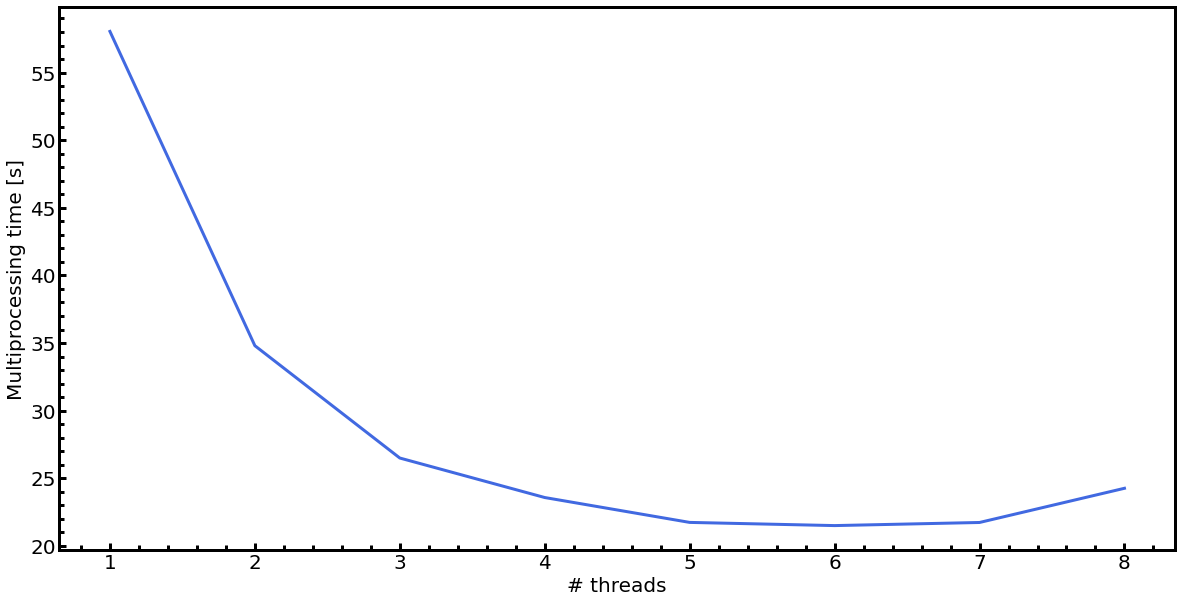

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,10))

ax.plot(nthreads, multi_time, color='royalblue', linewidth=3)
ax.set_xlabel('# threads', fontsize=20)
ax.set_ylabel('Multiprocessing time [s]', fontsize=20)

spines = ['left', 'bottom', 'top', 'right']
for spine in spines:
    ax.spines[spine].set_linewidth(3)
    
ax.tick_params(direction='in', which='major', labelsize=20, length=7, width=3)
ax.minorticks_on()
ax.tick_params(direction='in', which='minor', labelsize=15, length=5, width=3)

$\color{red}{\textbf{Time dependence with number of threads is not linear:}}$
$\color{red}{\textbf{this could be due to inter-processes communication time, which increases with #threads.}}$

## Q2: Consistent plotting

(This is about python's dectorators)

Write a decorator for the plots of all your papers. 

- Remember a decorator takes a function. 
- This function in turn should return a matplotlib figure object.
- Before the function is called, the decorator should intialize a matplotlib figure with the options that you like the most (fontsize, ticks, etc etc)
- After the figure it's done, the decorator should save it to pdf.

This is a great hack for your papers! You do this once and for all, and all plots in your paper will be beautifill, all with the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my python module [skywalker](https://github.com/dgerosa/skywalker).  

$\color{red}{\textbf{I will test it on two plots I put in a submitted paper}}$

In [86]:
def myplot(function):
  def wrapper(title_fig):
    fig, axs = function(title_fig)
    for i, ax in enumerate(axs.flat):
        ax.tick_params(direction='in', which='major', pad=8, labelsize=25, length=10, width=4, color='black', bottom=True, top=True, right=True, left=True)
        ax.tick_params(axis='both', labelleft=True, pad=8)
        ax.minorticks_on()
        ax.tick_params(direction='in', which='minor', labelsize=25, length=7, width=4, color='black', bottom=True, top=True, right=True, left=True)
        spines = ['left', 'bottom', 'top', 'right']
        thickness = 3
        for spine in spines:
            ax.spines[spine].set_linewidth(thickness)
            ax.spines[spine].set_color('black')
        
    fig.tight_layout()
    plt.savefig(title_fig, overwrite=True)
  return wrapper

In [52]:
@myplot
def test_plot(title_fig):
    path = '/Users/lunarampinelli/Documents/tesi_magistrale/cubes/imaging/'
    name = np.array([path+'H13CN/PDS_70_260GHz_LB_selfcaled_H13CN_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits',path+'HC15N/PDS_70_260GHz_LB_selfcaled_HC15N_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits',path+'DCN/PDS_70_230GHz_LB_selfcaled_DCN_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits', path+'CS/PDS_70_260GHz_LB_selfcaled_CS_robust2.0_1.4kms_4sigma.clean.image_M0.fits', path+'H2CO/PDS_70_230GHz_LB_selfcaled_H2CO_303_202_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits', path+'H2CO/PDS_70_230GHz_LB_selfcaled_H2CO_321_220_robust2.0_0.4kms_2sigma.clean.image_M0.fits', path+'H13COp/PDS_70_260GHz_LB_selfcaled_H13COp_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits',  path+'C2H/PDS_70_260GHz_LB_selfcaled_C2H_kepmask_robust2.0_0.4kms_2sigma.clean.image_M0.fits', path+'CO/PDS_70_230GHz_LB_selfcaled_12CO_start_-2.5kms_robust2.0_0.1kms_4sigma.clean.image_M0.fits', path+'CO/PDS_70_230GHz_LB_selfcaled_13CO_start_-2.5kms_robust2.0_0.2kms_4sigma.clean.image_M0.fits', path+'CO/PDS_70_230GHz_LB_selfcaled_C18O_start_-2.5kms_robust2.0_0.2kms_4sigma.clean.image_M0.fits', path+'PDS_70_LB1SB1_final_shift_to_LB3SB1_r2.fits'])
    name_lines = np.array(['H13CN', 'HC15N', 'DCN', 'CS', 'H2CO_0302', 'H2CO_2120', 'H13COp', 'C2H_7252', '12CO', '13CO', 'C18O', 'cont'])
    title = np.array(['H$^{13}$CN (3-2)', 'HC$^{15}$N (3-2)', 'DCN (3-2)', 'CS (5-4)', 'H$_2$CO (3$_{03}$-2$_{02}$)', 'H$_2$CO (3$_{21}$-2$_{20}$)', 'H$^{13}$CO$^+$ (3-2)', 'C$_2$H (3$_{7/2}$-2$_{5/2}$)', '$^{12}$CO (2-1)', '$^{13}$CO (2-1)', 'C$^{18}$O (2-1)', '855 $\mu$m continuum'])
    nu_rest = np.array([259.01179760, 258.15699640, 217.23853780, 244.93555650, 218.2221, 218.760066, 260.25533900, (262.0042+262.0064)/2, 230.5380, 220.3986, 219.56035410, 3.505615559745e+2])
    ncols=4
    nrows=3
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(35,20), dpi=150)
    for i, ax in enumerate(axs.flat):
       
        M = imagecube(name[i])
        if i!=((ncols*nrows)-1):
            M.data = M.jybeam_to_Tb_RJ(nu=nu_rest[i]*1e9)/1e3
        else:
            M.data = M.jybeam_to_Tb_RJ(nu=nu_rest[i]*1e9)
            
        im = ax.imshow(M.data, extent=M.extent, origin='lower', cmap='cmr.arctic', vmin=0)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cb = plt.colorbar(im, cax=cax)
        cb.ax.tick_params(axis='both', direction='in', which='major', pad=8, length=5, width=3, color='black', bottom=False, top=False, right=True, left=False, labelsize=25)
        cb.ax.minorticks_on()
        cb.ax.tick_params(axis='both', direction='in', which='minor', pad=8, length=3, width=3, color='black', bottom=False, top=False, right=True, left=False)
        cb.outline.set_linewidth(3)
        cb.outline.set_color('black')
        
        if i!=((ncols*nrows)-1):
            cb.set_label('(K km/s)', fontsize=30, labelpad=10)
        else:
            cb.set_label('(K)', fontsize=30, labelpad=10)

        ax.set_xlim(1.9, -1.9)
        ax.set_ylim(-1.9, 1.9)
        ax.set_xlabel('Offset (arcsec)', fontsize=35)
        ax.set_ylabel('Offset (arcsec)', fontsize=35)
        ax.set_title(title[i], fontsize=30, color='white', x=0.5, y=0.90)

        M.plot_beam(ax=ax, color='white')
        xc=[-0.2148]
        yc=[0.0319]
        xb=[0.0969]
        yb=[-0.1537]
        ax.plot(xc,yc, markersize=7, color='white', marker='o')
        ax.plot(xb,yb, markersize=7, color='white', marker='o')
    return fig, axs

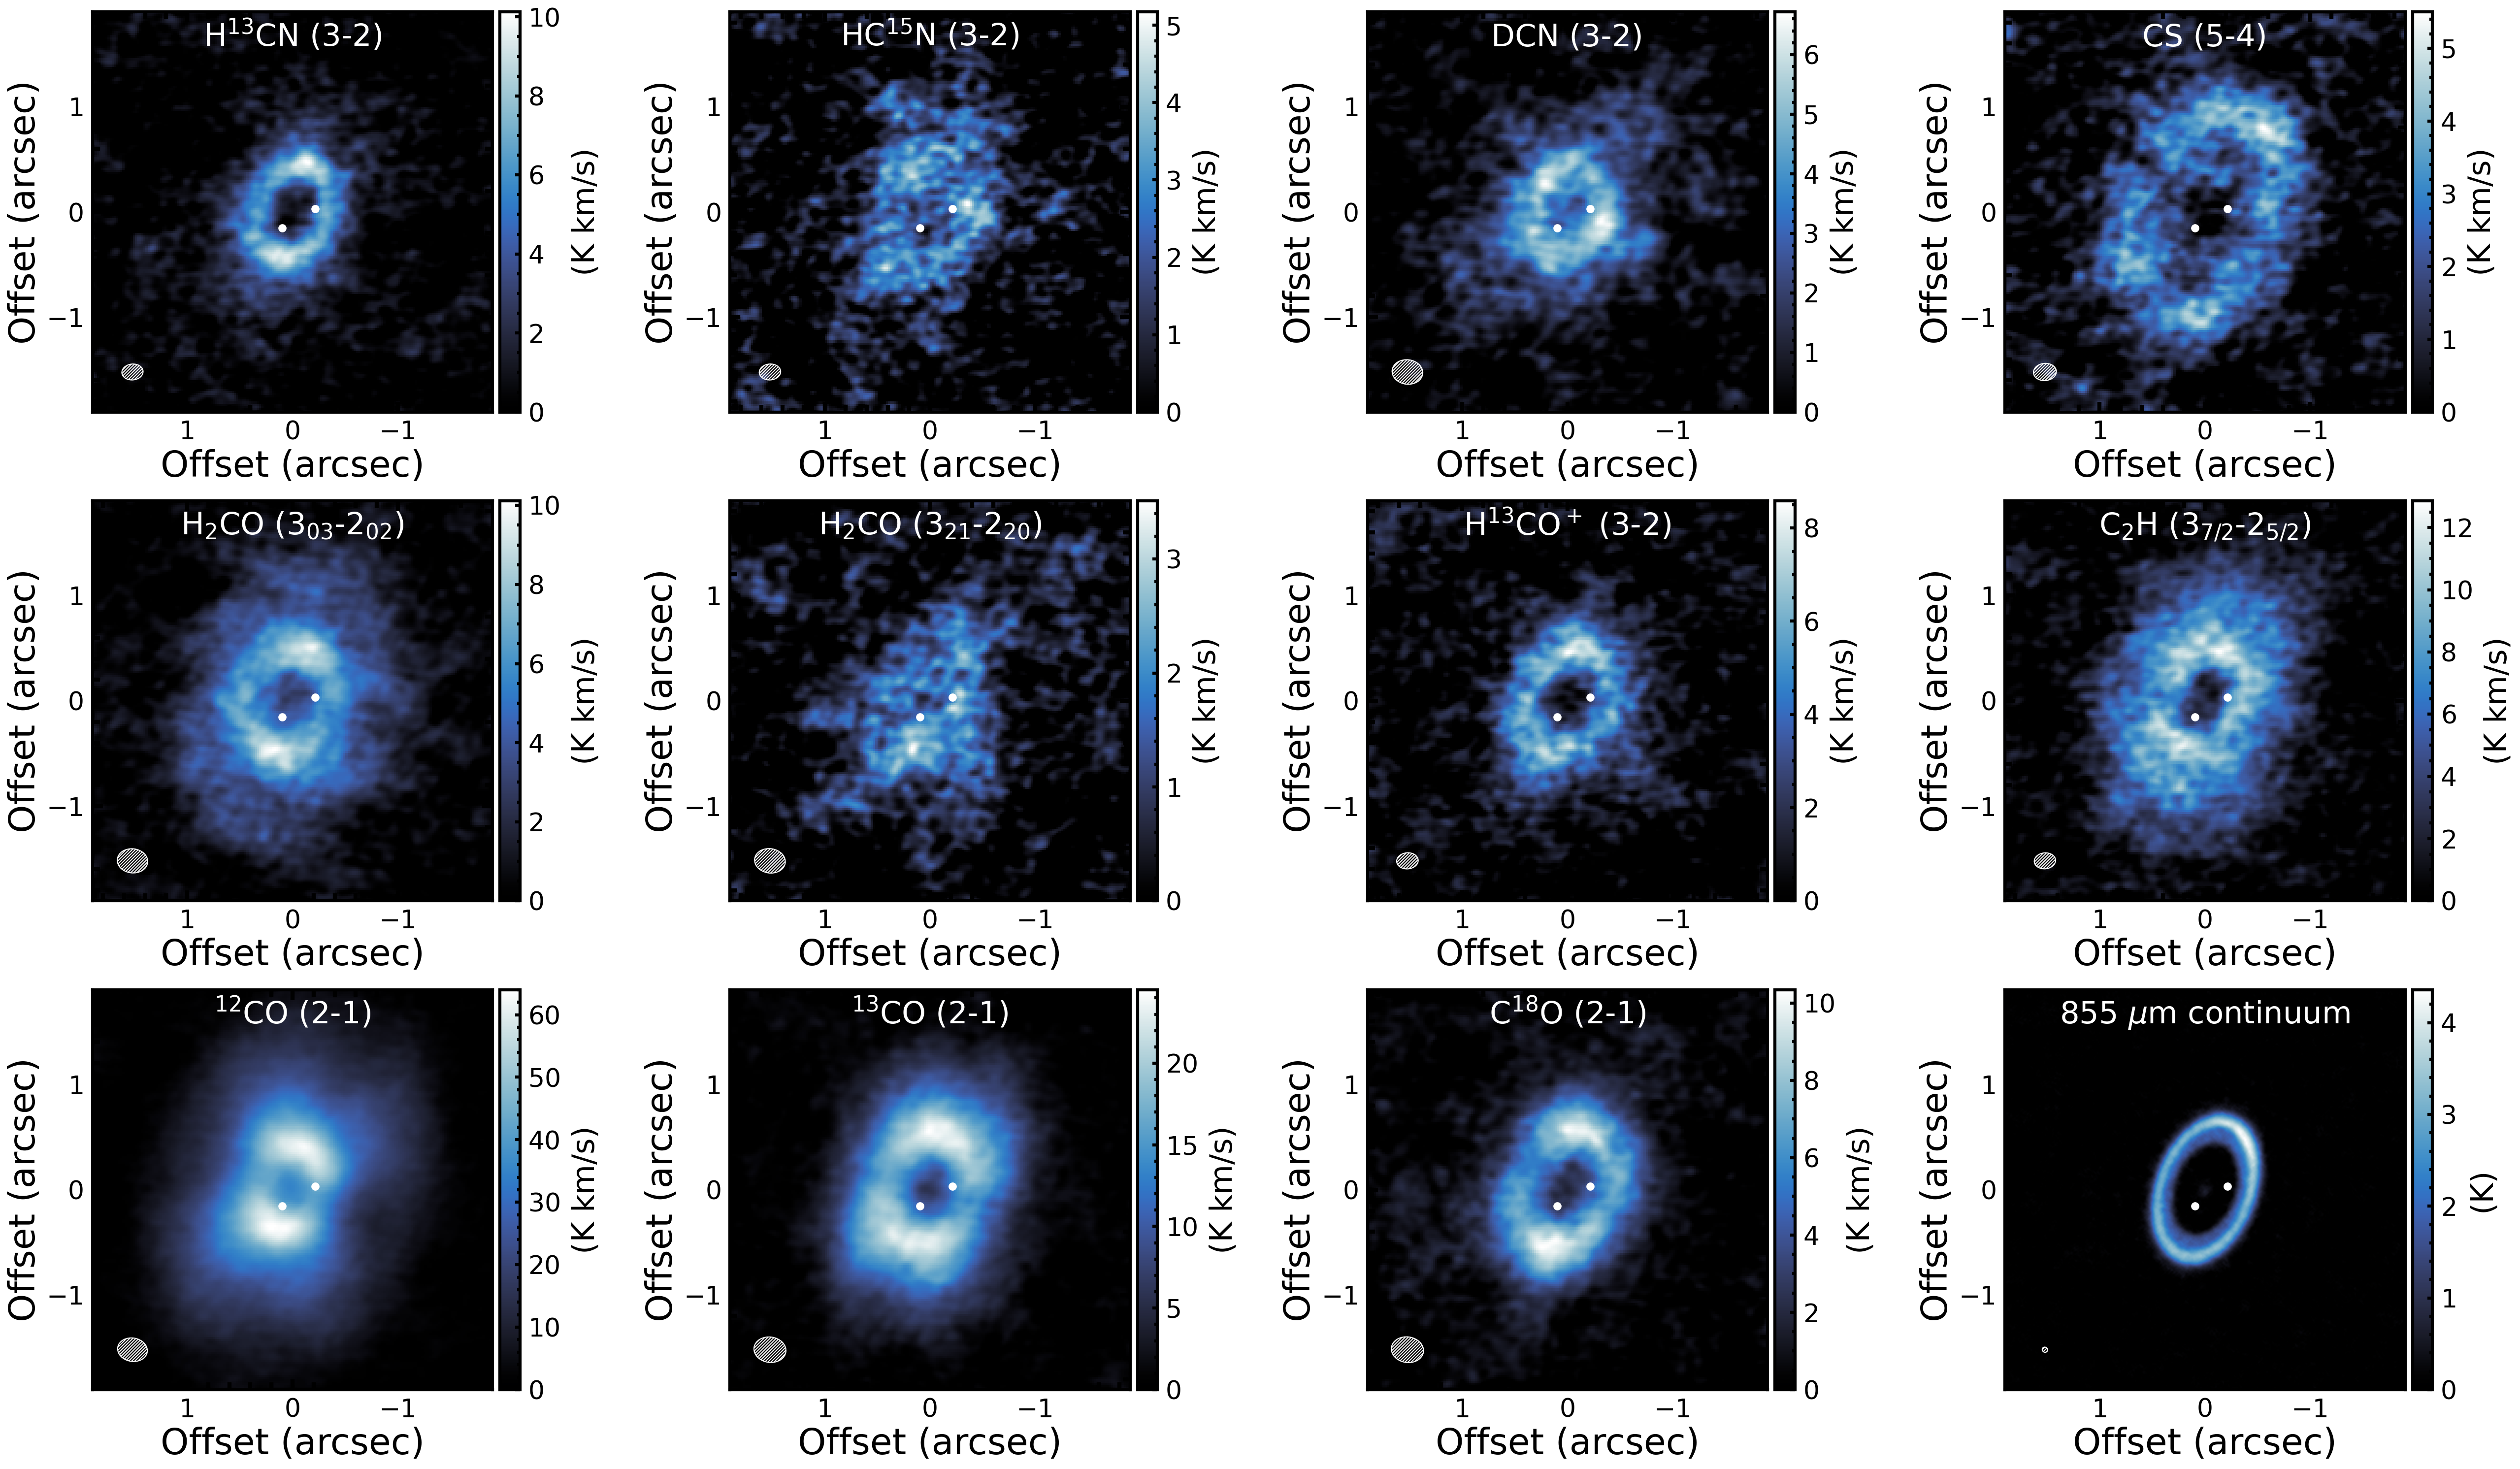

In [53]:
test_plot('M0_test.pdf')

In [93]:
@myplot
def plot_intensity(fig_title):
    ncols=3
    nrows=4
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(35,35), dpi=50)
    path = '/Users/lunarampinelli/Documents/tesi_magistrale/cubes/imaging/'
    name = np.array([path+'H13CN/PDS_70_260GHz_LB_selfcaled_H13CN_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits',path+'HC15N/PDS_70_260GHz_LB_selfcaled_HC15N_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits',path+'DCN/PDS_70_230GHz_LB_selfcaled_DCN_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits', path+'CS/PDS_70_260GHz_LB_selfcaled_CS_robust2.0_1.4kms_4sigma.clean.image_M0.fits', path+'H2CO/PDS_70_230GHz_LB_selfcaled_H2CO_303_202_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits', path+'H2CO/PDS_70_230GHz_LB_selfcaled_H2CO_321_220_robust2.0_0.4kms_2sigma.clean.image_M0.fits', path+'H13COp/PDS_70_260GHz_LB_selfcaled_H13COp_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits',  path+'C2H/PDS_70_260GHz_LB_selfcaled_C2H_kepmask_robust2.0_0.4kms_2sigma.clean.image_M0.fits', path+'CO/PDS_70_230GHz_LB_selfcaled_12CO_start_-2.5kms_robust2.0_0.1kms_4sigma.clean.image_M0.fits', path+'CO/PDS_70_230GHz_LB_selfcaled_13CO_start_-2.5kms_robust2.0_0.2kms_4sigma.clean.image_M0.fits', path+'CO/PDS_70_230GHz_LB_selfcaled_C18O_start_-2.5kms_robust2.0_0.2kms_4sigma.clean.image_M0.fits', path+'PDS_70_LB1SB1_final_shift_to_LB3SB1_r2.fits'])
    name_lines = np.array(['H13CN', 'HC15N', 'DCN', 'CS', 'H2CO_0302', 'H2CO_2120', 'H13COp', 'C2H_7252', '12CO', '13CO', 'C18O', 'cont'])
    title = np.array(['H$^{13}$CN (3-2)', 'HC$^{15}$N (3-2)', 'DCN (3-2)', 'CS (5-4)', 'H$_2$CO (3$_{03}$-2$_{02}$)', 'H$_2$CO (3$_{21}$-2$_{20}$)', 'H$^{13}$CO$^+$ (3-2)', 'C$_2$H (3$_{7/2}$-2$_{5/2}$)', '$^{12}$CO (2-1)', '$^{13}$CO (2-1)', 'C$^{18}$O (2-1)', '855 $\mu$m continuum'])
    nu_rest = np.array([259.01179760, 258.15699640, 217.23853780, 244.93555650, 218.2221, 218.760066, 260.25533900, (262.0042+262.0064)/2, 230.5380, 220.3986, 219.56035410, 3.505615559745e+2])

    for i, ax in enumerate(axs.flat):
        ax.set_xlabel('Radius (arcsec)', fontsize=35)
        ax.set_ylabel('Integrated intensity (K km/s)', fontsize=35)

        M = imagecube(name[i])   
        r, T, dT = M._radial_profile_2D(assume_correlated=True, x0=0.0, y0=0.0, inc=51.7, PA=160.4, mask_frame='disk')
        if i!=((ncols*nrows)-1):
            T = M.jybeam_to_Tb_RJ(data=T, nu=nu_rest[i]*1e9)/1e3
            dT = M.jybeam_to_Tb_RJ(data=dT, nu=nu_rest[i]*1e9)/1e3
        else:
            T = M.jybeam_to_Tb_RJ(data=T, nu=nu_rest[i]*1e9)
            dT = M.jybeam_to_Tb_RJ(data=dT, nu=nu_rest[i]*1e9)
            
        ax.plot(r, T, color='royalblue', linewidth=3)
        ax.fill_between(r, T-dT, T+dT, color='royalblue', alpha=0.2)

        ax.set_title(title[i], fontsize=35, x=0.5, y=0.88)
        ylim = T.max() + 1.5
        ax.fill_between([0, M.bmaj], -0.1, ylim, hatch='/', color='none',edgecolor='grey')
        ax.set_xlim(0,2)
        ax.set_ylim(-0.1,ylim)
    return fig, axs

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


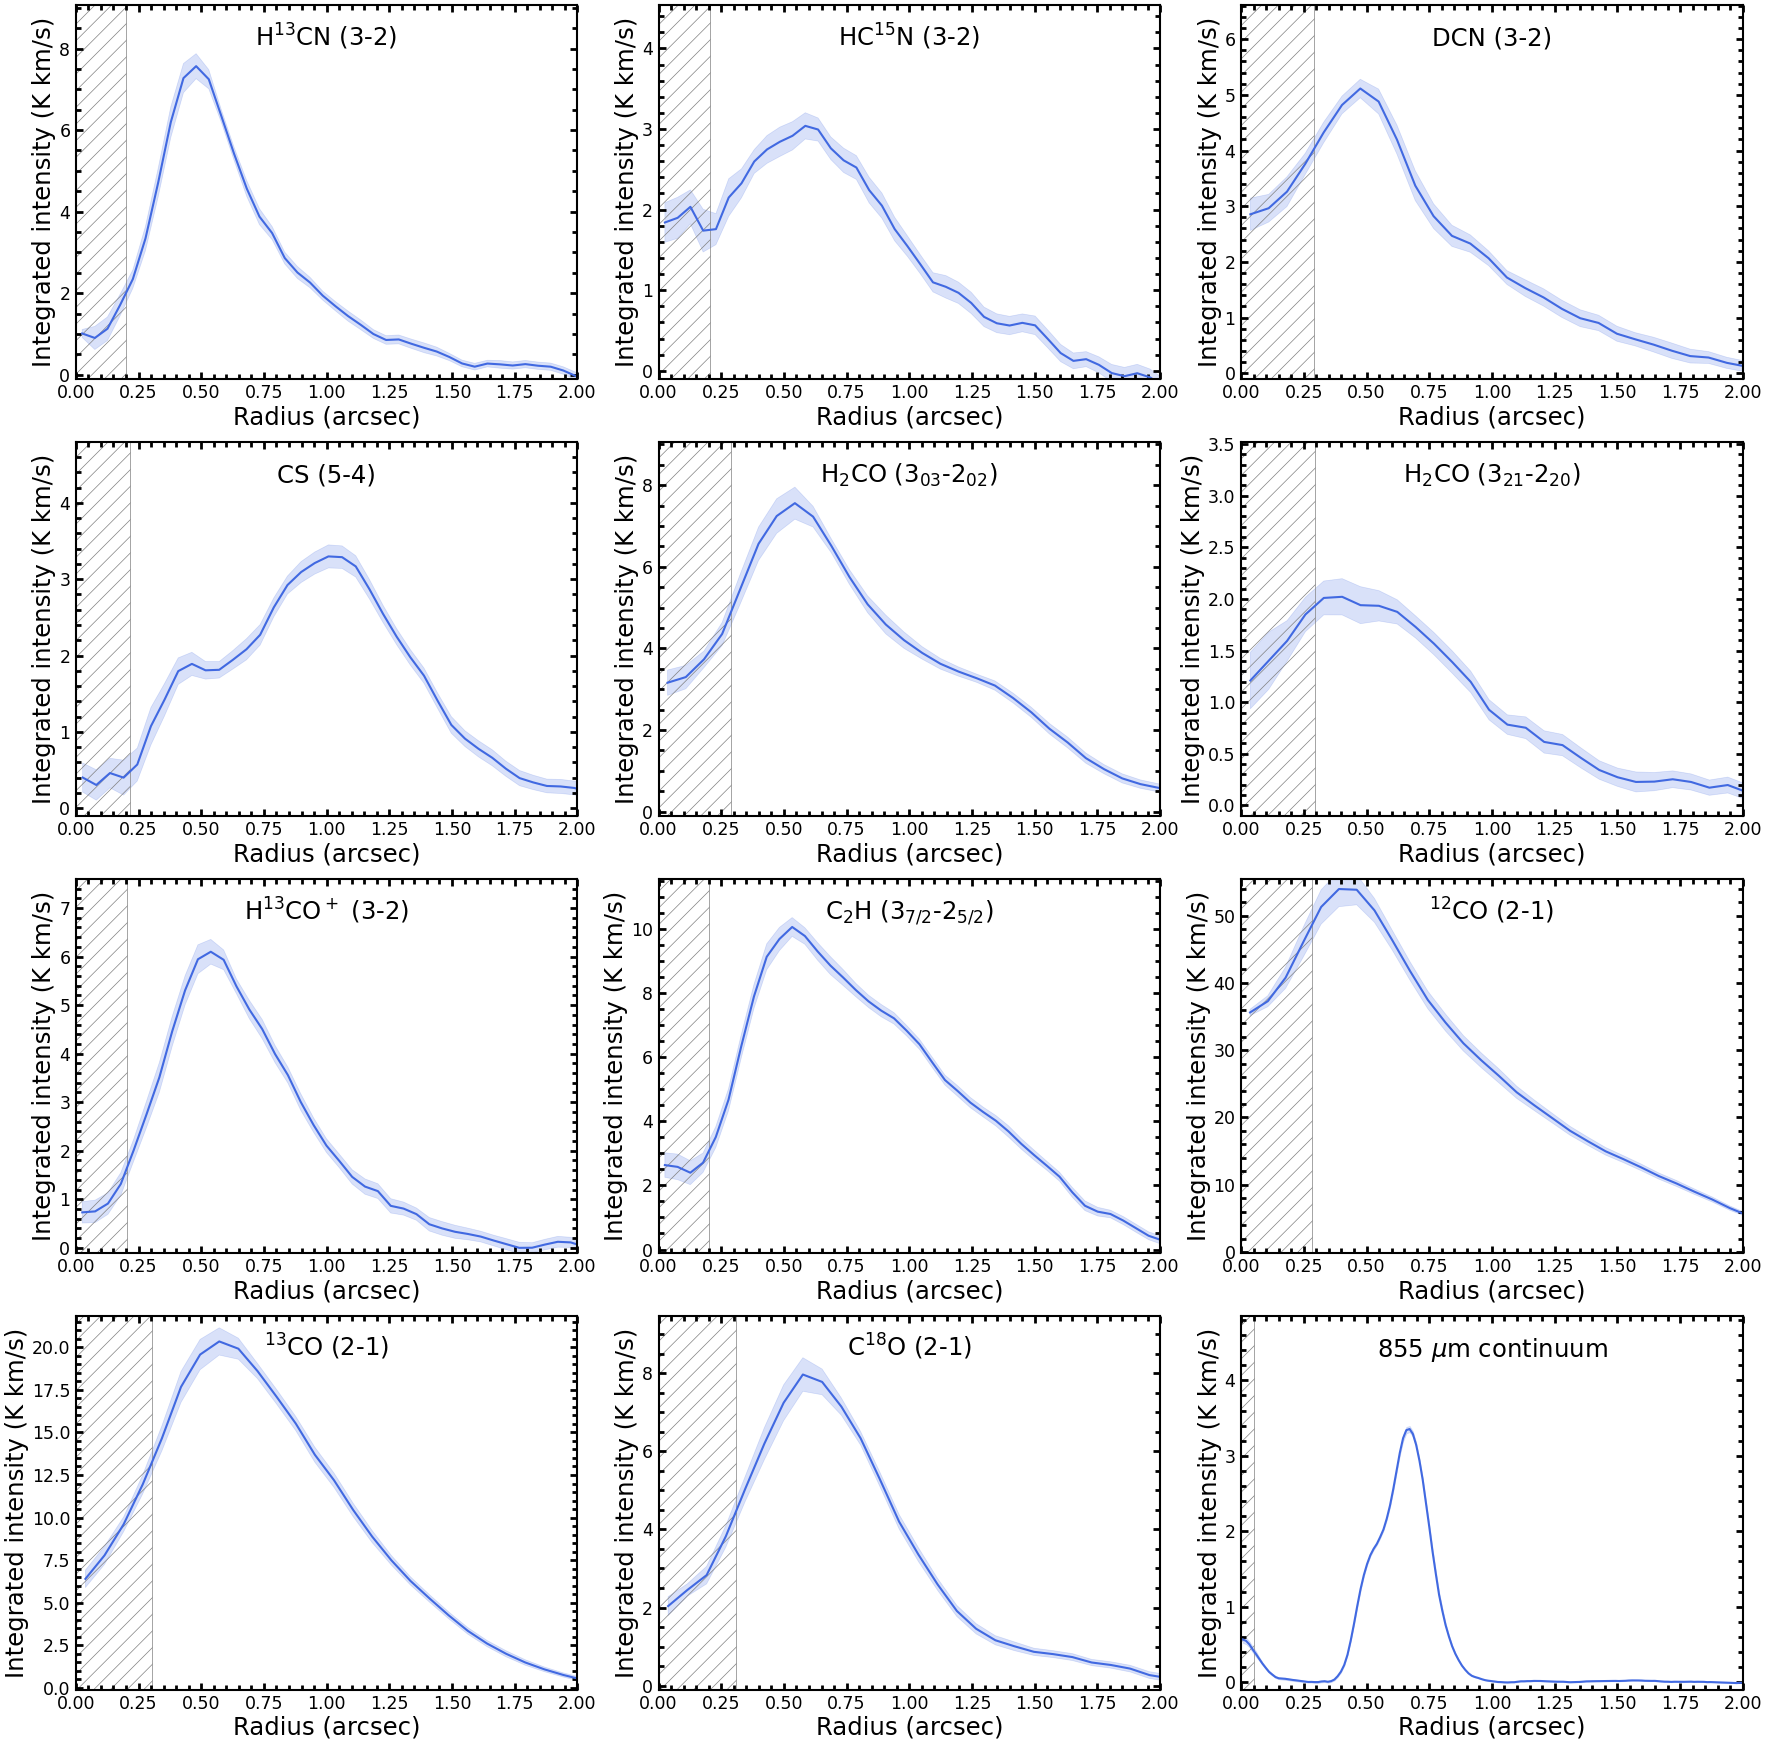

In [94]:
plot_intensity('int_test.pdf')